In [1]:
import sys
sys.path.insert(0,'../')
from libs.ssl_task import CPC
from libs.ssl_data import SSLHBNDataModule
%load_ext autoreload
%autoreload 2

In [13]:
import wandb
import os
run = wandb.init()
artifact_dir = 'artifacts/model-0cu5slnx'
for version in range(10):
    if os.path.exists(artifact_dir):
        print(f"Artifact directory {artifact_dir} already exists. Skipping download.")
        break
    artifact = run.use_artifact(f'sccn/eeg-ssl/model-0cu5slnx:v{version}', type='model')
    artifact_dir = artifact.download()

wandb: Currently logged in as: dt-young112 (sccn) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Downloading large artifact model-0cu5slnx:v0, 1800.34MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.9


Artifact directory /home/dung/eeg-ssl/notebooks/artifacts/model-0cu5slnx:v0 already exists. Skipping download.


In [2]:
# load config from runs/config_CPC.yaml
import yaml
import lightning as L
with open('../runs/config_CPC.yaml', 'r') as f:
    config = yaml.safe_load(f)

ssl_task = CPC()
config['data']['ssl_task'] = ssl_task
config['data']['window_len_s'] = 20
config['data']['num_workers'] = 2

config['model']['init_args']['contextualizer_path'] = 'libs.ssl_model.BENDRContextualizer'
config['model']['init_args']['contextualizer_kwargs'] = {'in_features': 512, 'start_token': None}

config['trainer']['callbacks'] = None
config['trainer']['logger'] = None

trainer = L.Trainer(**config['trainer'])
cpc_model = CPC.CPCLit(downsampling_factor=96, **config['model']['init_args'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
from collections import defaultdict
attributes = ['p_factor']
version_scores = defaultdict(list)
for attr in attributes:
    config['data']['target_label'] = attr
    print('Loading data module...')
    litDataModule = SSLHBNDataModule(**config['data'])
    litDataModule.setup(stage='fit')

    artifact_dir = 'artifacts/model-0cu5slnx'
    for version in range(10):
        artifact_path = f'{artifact_dir}:v{version}/model.ckpt'
        print(f'Loading model from {artifact_path}...')
        scores = trainer.validate(model=cpc_model, ckpt_path=artifact_path, datamodule=litDataModule)
        version_scores[attr].append(scores)


In [6]:
metrics = ['val_Regressor/mae', 'val_Regressor/subject_with_mean_mae']

[{'val_loss_epoch': 0.014139841310679913, 'val_Regressor/R2': 0.3281303968041406, 'val_Regressor/concordance': 0.41836470152561833, 'val_Regressor/NRMSE': 50.32090192390024, 'val_Regressor/mse': 0.510043524914169, 'val_Regressor/mae': 0.5694009267860362, 'val_Regressor/subject_with_mean_R2': 0.40828329554569764, 'val_Regressor/subject_with_median_R2': 0.37182480861835876, 'val_Regressor/subject_with_mean_concordance': 0.44685581782396844, 'val_Regressor/subject_with_median_concordance': 0.4099946640198024, 'val_Regressor/subject_with_mean_NRMSE': -37.9903798040602, 'val_Regressor/subject_with_median_NRMSE': -39.14327066468587, 'val_Regressor/subject_with_mean_mse': 0.4640833228204816, 'val_Regressor/subject_with_median_mse': 0.4926777086657324, 'val_Regressor/subject_with_mean_mae': 0.5440849974128646, 'val_Regressor/subject_with_median_mae': 0.5569376696864649, 'val_Regressor/subject_iqr_mean': 0.315483957529068, 'val_Regressor/subject_iqr_median': 0.3113628029823303, 'val_Regressor/s

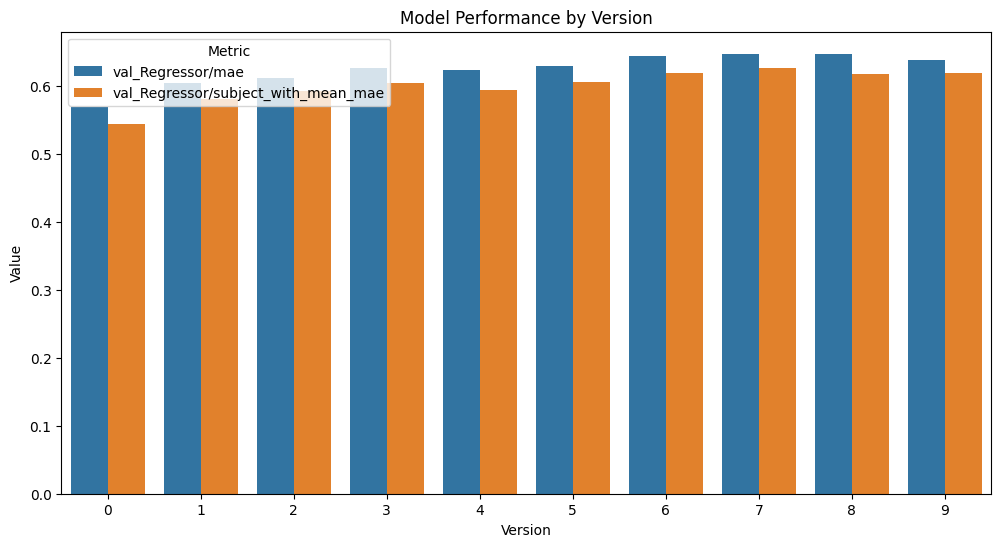

In [11]:
# plot the metrics for each version from scores
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_metrics(scores, metrics, attributes):
    # Create a DataFrame to hold the scores
    data = []
    # for version, score in enumerate(scores):
    for attr, score in scores.items():
        for version, version_score in enumerate(score):
            print(version_score)
            for metric in metrics:
                    data.append({
                        'version': version,
                        'metric': metric,
                        'attribute': attr,
                        'value': version_score[0][metric]
                    })
    df = pd.DataFrame(data)

    # Set the figure size
    plt.figure(figsize=(12, 6))

    # Create a bar plot
    sns.barplot(x='version', y='value', hue='metric', data=df)

    # Set the title and labels
    plt.title('Model Performance by Version')
    plt.xlabel('Version')
    plt.ylabel('Value')

    # Show the legend
    plt.legend(title='Metric')

    # Show the plot
    plt.show()
plot_metrics(version_scores, metrics, attributes)